In [159]:
#%pip install Pandas
#%pip install keras
#%pip install tensorflow
#%pip install scikit-learn

In [160]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import tensorflow as tf
import keras
import sklearn.decomposition
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
import sklearn.linear_model
import sklearn.metrics
np.set_printoptions(threshold=20)


Contents 
- [1. Introduction](#1-introduction)
- [2. Dataset and initial inspection](#2-dataset-and-initial-inspection)
- [3. Analysing and formatting the dataset](#3-analysing-and-formatting-the-dataset)
  - [3.1 Formatting the dataset](#3-1-formatting-the-dataset)
  - [3.2 Analysing the dataset](#3-2-analysing-the-dataset)
- [4. Fitting a linear and nonlinear model to the dataset](#4-Fitting-a-linear-and-non-linear-model-to-the-dataset)
  - [4.1 Applying Principal Component Analysis](#4-1-Applying-Principal-Component-Analysis)
  - [4.2 Creating a deep learning model](#4-2-Creating-a-deep-learning-model)
- [5. Conclusion](#4-conclusion)
- [6. Discussion](#4-discussion)



# 1. Introduction

Predicting for how much houses will sell will help current and prospective homeowners navigate the cluttered landscape of real estate. In this report we will explore how the dataset is structured, how to format the dataset to allow us to fit a model to it, and the different kinds of models we can fit to the dataset. We will start by formatting the dataset to include solely numeric values. Then analysing the dataset to find how the variables are connected to each other. Next we will fit both a linear model and a nonlinear model to the data. The linear model will use Principal Component Analysis as a baseline and the nonlinear model will be a fully connected neural network. 

# 2. Dataset and initial inspection

The dataset provided houses a lot of different parameters on which the price of a house can depend. Just to give a couple examples with their usual impact on the house price from general knowledge and experience:

- LotArea: the area of the land on which a house stands. In general the higher this number the higher the price.
- Bedroom: number of bedrooms above ground. In general the higher the number of bedrooms the higher the price.

There are a lot more prameters that are contained in the dataset. For more detail on this consult the data_description.txt file. 

The total of 79 explanatory variables quantify almost all physical properties of the houses in the dataset. These in some way try to include different human preferences in an objective manner by assessing the quality of materials and the functionality rating of the home. In the end these preferences can differ from person to person as everybody has a different eye for aesthetics. The dataset therefore should be interpreted as how it is structured, an objective assessment of the physical features of the house, and any model that is fit to it should be treated as an objective estimator for the selling price.

# 3. Analysing and formatting the dataset

### 3.1 Formatting the dataset

When analysing the dataset and consulting the data_description.txt file provided. One can notice that there are some non-numeric values. When importing the files through Pandas some of the values will format to NaN values. Before we are able to fit a model to the dataset we have to reformat these values to numeric values. The data_description.txt file was used to get all the different kinds of non-numeric values. A for loop is then used to assign numbers to each non-numeric value. This ensures that linear regression can be used.

The for loop is primitive and ineficient, but due to the fast computer cores of today it still runs fast enough. 

After assigning numeric values to every data point, the entire dataset is columnwise standard normalised and split into an input feature array and an output vector. 

In [161]:
# accessing the csv files

train_csv = pd.read_csv("./house-prices-advanced-regression-techniques/train.csv")
test_csv = pd.read_csv("./house-prices-advanced-regression-techniques/test.csv")

data_fields = train_csv.columns.values

print(train_csv)
print(len(data_fields))
print(test_csv)


        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

In [162]:
# formatting the data

# change the NaN values to zero

train_csv = train_csv.mask(pd.isna(train_csv), 0)
test_csv = test_csv.mask(pd.isna(test_csv), 0)

# uniformly change non numeric values to a numeric value

classes = { 
    "mszoning_classes"          :     ["A","C","FV","I","RH","RL","RP","RM"],
    "street_classes"            :      ["Grvl","Pave","C (all)"],
    "alley_classes"             :      ["Grvl","Pave","NA"],
    "lotshape_classes"          :      ["Reg","IR1","IR2","IR3"],
    "landcontour_classes"       :      ["Lvl","Bnk","HLS","Low"],
    "utilities_classes"         :      ["AllPub","NoSewr","NoSeWa","ELO"],
    "lotconfig_classes"         :      ["Inside","Corner","CulDSac","FR2","FR3"],
    "landslope_classes"         :      ["Gtl","Mod","Sev"],
    "neighborhood_classes"      :      ["Blmngtn","Blueste","BrDale","BrkSide","ClearCr","CollgCr","Crawfor","Edwards","Gilbert","IDOTRR","MeadowV","Mitchel","Names","NoRidge","NPkVill","NridgHt","NWAmes","OldTown","SWISU","Sawyer","SawyerW","Somerst","StoneBr","Timber","Veenker"],
    "condition1_classes"        :      ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe", "NAmes"],
    "condition2_classes"        :      ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe", "NAmes"],
    "bldgtype_classes"          :      ["1Fam","2FmCon","Duplx","TwnhsE","TwnhsI", "NAmes"],
    "housestyle_classes"        :      ["1Story","1.5Fin","1.5Unf","2Story","2.5Fin","2.5Unf","SFoyer","SLvl"],
    "roofstyle_classes"         :      ["Flat","Gable","Gambrel","Hip","Mansard","Shed"],
    "roofmatl_classes"          :      ["ClyTile","CompShg","Membran","Metal","Roll","Tar","WdShake","WdShngl", "2fmCon","Duplex", "Twnhs"],
    "exterior1st_classes"       :      ["AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing"],
    "exterior2nd_classes"       :      ["AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing"],
    "masvnrtype_classes"        :      ["BrkCmn","BrkFace","CBlock","None","Stone"],
    "exterqual_classes"         :      ["Ex","Gd","TA","Fa","Po"],
    "extercond_classes"         :      ["Ex","Gd","TA","Fa","Po"],
    "foundation_classes"        :      ["BrkTil","CBlock","PConc","Slab","Stone","Wood"],
    "bsmtqual_classes"          :      ["Ex","Gd","TA","Fa","Po","NA", "Tar&Grv"],
    "bsmtcond_classes"          :      ["Ex","Gd","TA","Fa","Po","NA"],
    "bsmtexposure_classes"      :      ["Gd","Av","Mn","No","NA", "Wd Shng", "CmentBd", "Brk Cmn"],
    "bsmtfintype1_classes"      :      ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
    "bsmtfintype2_classes"      :      ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"],
    "heating_classes"           :      ["Floor","GasA","GasW","Grav","OthW","Wall"],
    "heatingqc_classes"         :      ["Ex","Gd","TA","Fa","Po"],
    "centralair_classes"        :      ["N", "Y"],
    "electrical_classes"        :      ["SBrkr","FuseA","FuseF","FuseP","Mix"],
    "kitchenqual_classes"       :      ["Ex","Gd","TA","Fa","Po"],
    "functional_classes"        :      ["Typ","Min1","Min2","Mod","Maj1","Maj2","Sev","Sal"],
    "fireplacequ_classes"       :      ["Ex","Gd","TA","Fa","Po","NA"],
    "garagetype_classes"        :      ["2Types","Attchd","Basment","BuiltIn","CarPort","Detchd","NA"],
    "garagefinish_classes"      :      ["Fin","RFn","Unf","NA"],
    "garagequal_classes"        :      ["Ex","Gd","TA","Fa","Po","NA"],
    "garagecond_classes"        :      ["Ex","Gd","TA","Fa","Po","NA"],
    "paveddrive_classes"        :      ["Y","P","N"],
    "poolqc_classes"            :      ["Ex","Gd","TA","Fa","NA"],
    "fence_classes"             :      ["GdPrv","MnPrv","GdWo","MnWw","NA"],
    "miscfeature_classes"       :      ["Elev","Gar2","Othr","Shed","TenC","NA"],
    "saletype_classes"          :      ["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"],
    "salecondition_classes"     :      ["Normal","Abnorml","AdjLand","Alloca","Family","Partial"]
}

## Changing the non-numeric values to numeric
enumerate = range(1,50)
for key in classes:
    for i,j in zip(classes[key], enumerate):
        train_csv = train_csv.mask(train_csv == i, j)
        test_csv = test_csv.mask(test_csv == i, j)


print("train_csv")
print(train_csv)
print("test_csv")
print(test_csv)

train_csv
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60        6         65.0     8450      2     0        1   
1        2          20        6         80.0     9600      2     0        1   
2        3          60        6         68.0    11250      2     0        2   
3        4          70        6         60.0     9550      2     0        2   
4        5          60        6         84.0    14260      2     0        2   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60        6         62.0     7917      2     0        1   
1456  1457          20        6         85.0    13175      2     0        1   
1457  1458          70        6         66.0     9042      2     0        1   
1458  1459          20        6         68.0     9717      2     0        1   
1459  1460          20        6         75.0     9937      2     0        1   

     LandContour Utilities  ... PoolArea 

In [163]:
## Split x and y
train_x = train_csv.drop("SalePrice", axis=1)
train_x = train_x.drop("Id", axis=1).to_numpy() ## drop the salesprice and ID, salesprice is for the output matrix and ID is uncorrelated
train_y = train_csv["SalePrice"].to_numpy()
test_x = test_csv.drop("Id", axis=1).to_numpy()
print(train_y)
print(train_x)
print(type(train_x[0,2]))


[208500 181500 223500 ... 266500 142125 147500]
[[60 6 65.0 ... 2008 1 1]
 [20 6 80.0 ... 2007 1 1]
 [60 6 68.0 ... 2008 1 1]
 ...
 [70 6 66.0 ... 2010 1 1]
 [20 6 68.0 ... 2010 1 1]
 [20 6 75.0 ... 2008 1 1]]
<class 'float'>


In [164]:
# standard normalise the data

means = []
stds = []

for i in range(len(train_x[0])):
    means.append(np.mean(train_x[:,i]))
    stds.append(np.std(train_x[:,i]))

for i in range(len(train_x[0])):
    train_x[:,i] = (train_x[:,i] - means[i]) / stds[i]
    test_x[:,i] = (test_x[:,i] - means[i]) / stds[i]

# print(train_x)
# print(test_x)


### 3.2 Analysing the dataset

When looking at the number of input features we see that this dataset has a relatively high dimensionality. This could pose a problem if we want to fit a model to the dataset. To find out if it is possible to drop features we will check the different variances of the dataset.

We can check which features have the most effect on the pricing by finding the level of correlation of the feature to the sale price. There we can see that some features are strongly correlated to the price and others are negatively correlated. This is generalised however over the full training dataset, making it so that the correlation is a good indicator of how a feature affects the price, yet the exact effect might be different.

In [165]:
price_corr = train_csv.corr()['SalePrice'].sort_values(ascending=False)
for i in range(len(price_corr)):
    print(price_corr.index[i], '\t \t' ,price_corr.values[i], '\n') 

SalePrice 	 	 1.0 

OverallQual 	 	 0.7909816005838053 

GrLivArea 	 	 0.7086244776126515 

GarageCars 	 	 0.6404091972583519 

GarageArea 	 	 0.6234314389183622 

TotalBsmtSF 	 	 0.6135805515591943 

1stFlrSF 	 	 0.6058521846919153 

FullBath 	 	 0.5606637627484453 

TotRmsAbvGrd 	 	 0.5337231555820284 

YearBuilt 	 	 0.5228973328794967 

YearRemodAdd 	 	 0.5071009671113866 

MasVnrArea 	 	 0.4726144990045735 

Fireplaces 	 	 0.46692883675152763 

MasVnrType 	 	 0.4197113734867257 

BsmtFinSF1 	 	 0.3864198062421535 

FireplaceQu 	 	 0.3422158247720578 

WoodDeckSF 	 	 0.32441344456812926 

2ndFlrSF 	 	 0.31933380283206736 

OpenPorchSF 	 	 0.31585622711605504 

SaleCondition 	 	 0.2925675848571315 

HalfBath 	 	 0.28410767559478256 

LotShape 	 	 0.2677593139178233 

LotArea 	 	 0.2638433538714051 

GarageYrBlt 	 	 0.2613664351029629 

CentralAir 	 	 0.25132816384015516 

BsmtFullBath 	 	 0.22712223313149427 

RoofStyle 	 	 0.22240529240713863 

BsmtUnfSF 	 	 0.21447910554696928 

Pa

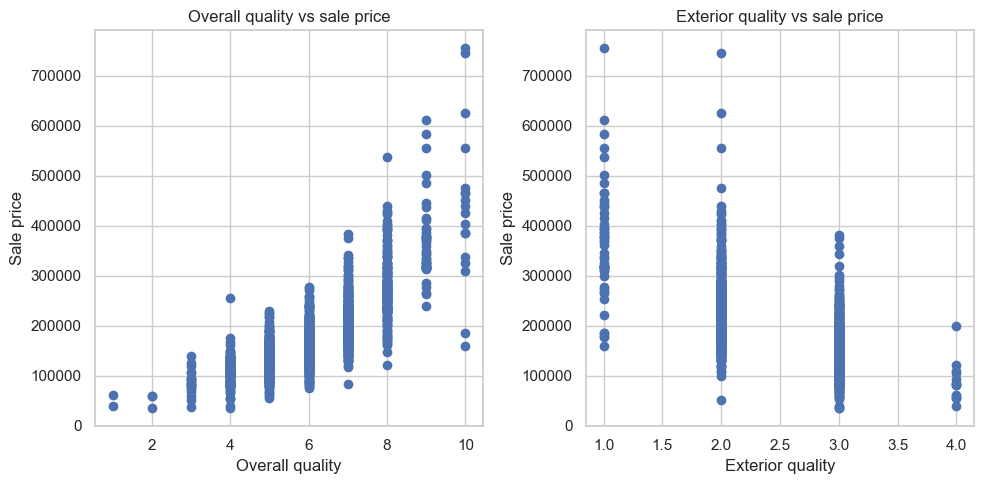

In [166]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(train_csv['OverallQual'], train_csv['SalePrice'])
plt.title("Overall quality vs sale price")
plt.ylabel('Sale price')
plt.xlabel("Overall quality")
plt.subplot(122)
plt.scatter(train_csv['ExterQual'], train_csv['SalePrice'])
plt.title("Exterior quality vs sale price")
plt.ylabel('Sale price')
plt.xlabel("Exterior quality")

plt.tight_layout()

Finally we can also check how all features are correlated to one another. This then gives us the Pearson Correlation Matrix.

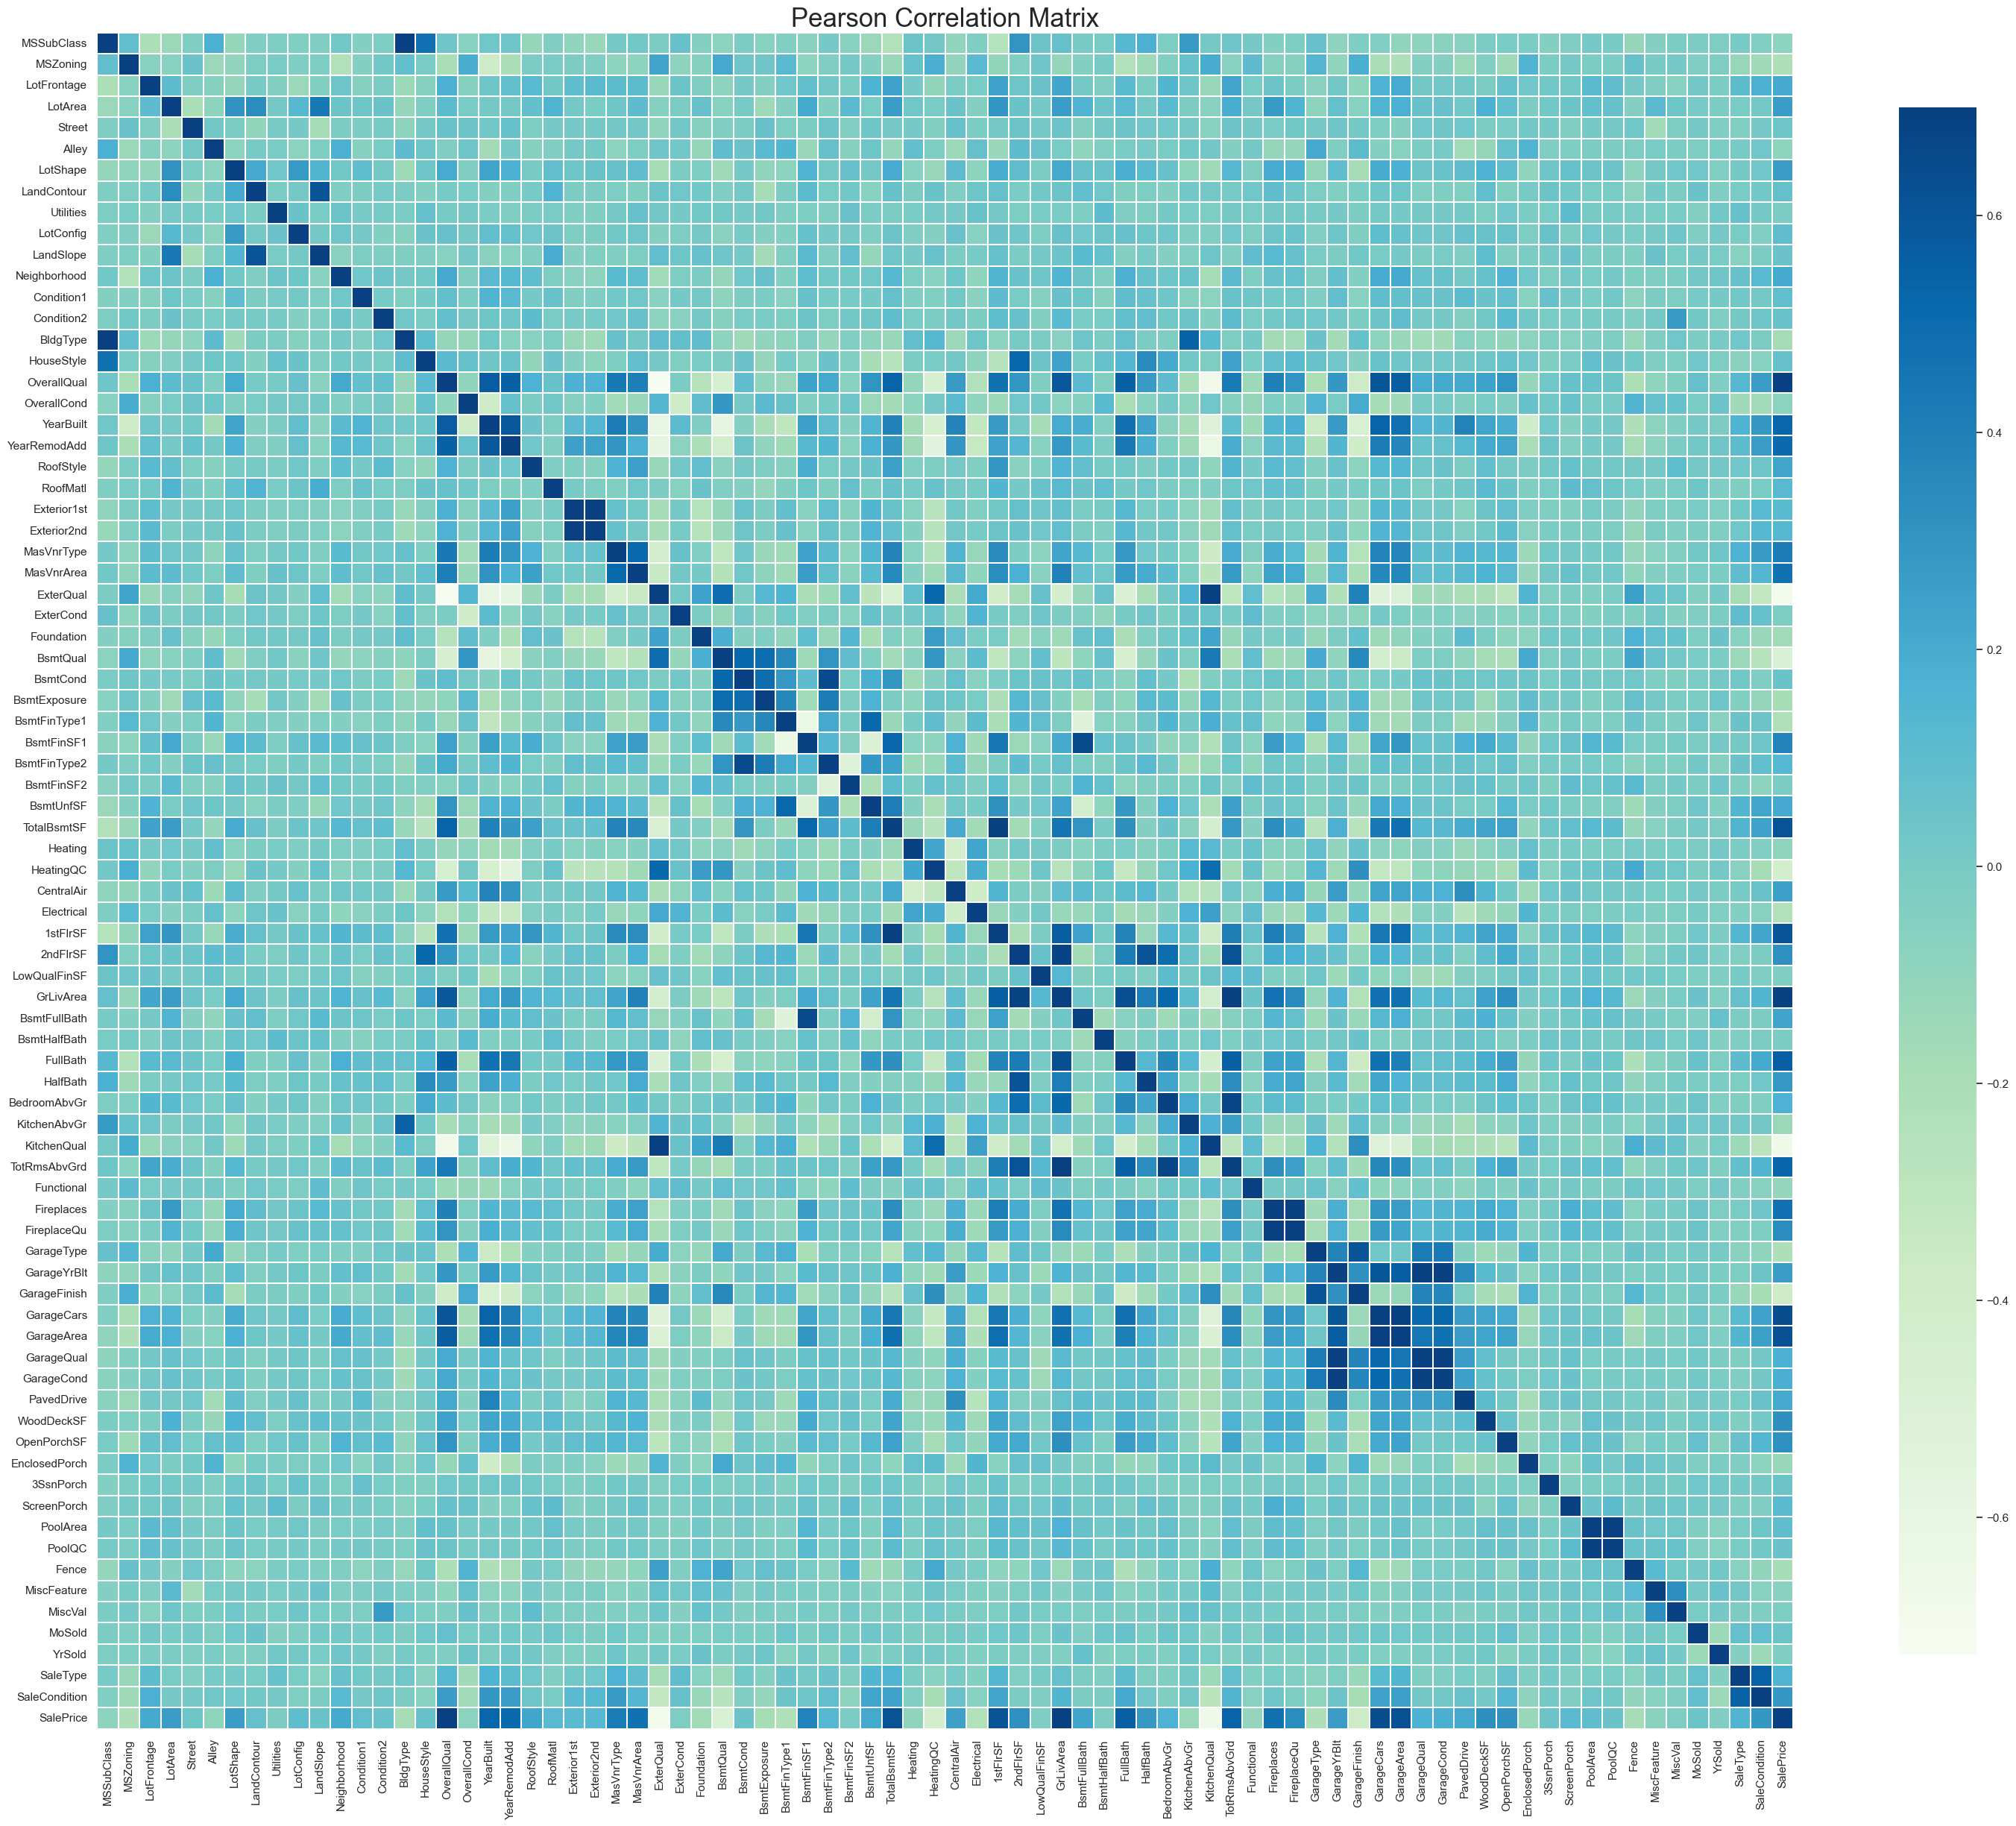

In [167]:
sns.set_theme(style='whitegrid', font_scale=1)

plt.figure(figsize=(30,30))
plt.title('Pearson Correlation Matrix',fontsize=25)
sns.heatmap(train_csv.drop('Id', axis=1).corr(),linewidths=0.1,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=False, annot_kws={"size":7}, cbar_kws={"shrink": .7})
plt.tight_layout()

From this analysis we can conclude that almost all of the features that are in the dataset are in some way or another relevant to the housing price. There are some that have a relatively low variance when the sale price is the target variable, but when any other variable is the target the variables with a lower variance can have a relatively high impact. Therefore we do not drop any features and use different methods to lower the dimensionality of the dataset. 

# 4. Fitting a linear and nonlinear model to the dataset

Now that we have a better feeling for how the dataset is structured and how each feature impacts the sale price we can begin with fitting a model to the dataset. Firstly we will try a linear model. Given the large amount of dimensions in the dataset we need to bring down the dimensionality. This can be done through artificial feature engineering. A quick and dirty way to do this is Principal Component Analysis (PCA). This allows us to evaluate the total variance of the dataset and find a set of higher dimensional axes that encompass most of the variance of the dataset. Through this we lose little interaction between the features themselves and the features and the output whilst also being able to reduce the dimensionality of the dataset.

### 4.1 Applying Principal Component Analysis

After application of PCA one can find how many dimensions are required after PCA to get the desired explained variance. For this we set a threshold of at least 80% of the variance to be explained. This results in a dimension of at least 34. We will choose 35 just to be safe.

In [168]:
# apply pca to the dataset

pca = sklearn.decomposition.PCA(n_components=79)

x_train = pca.fit_transform(train_x)
x_test = pca.transform(test_x)

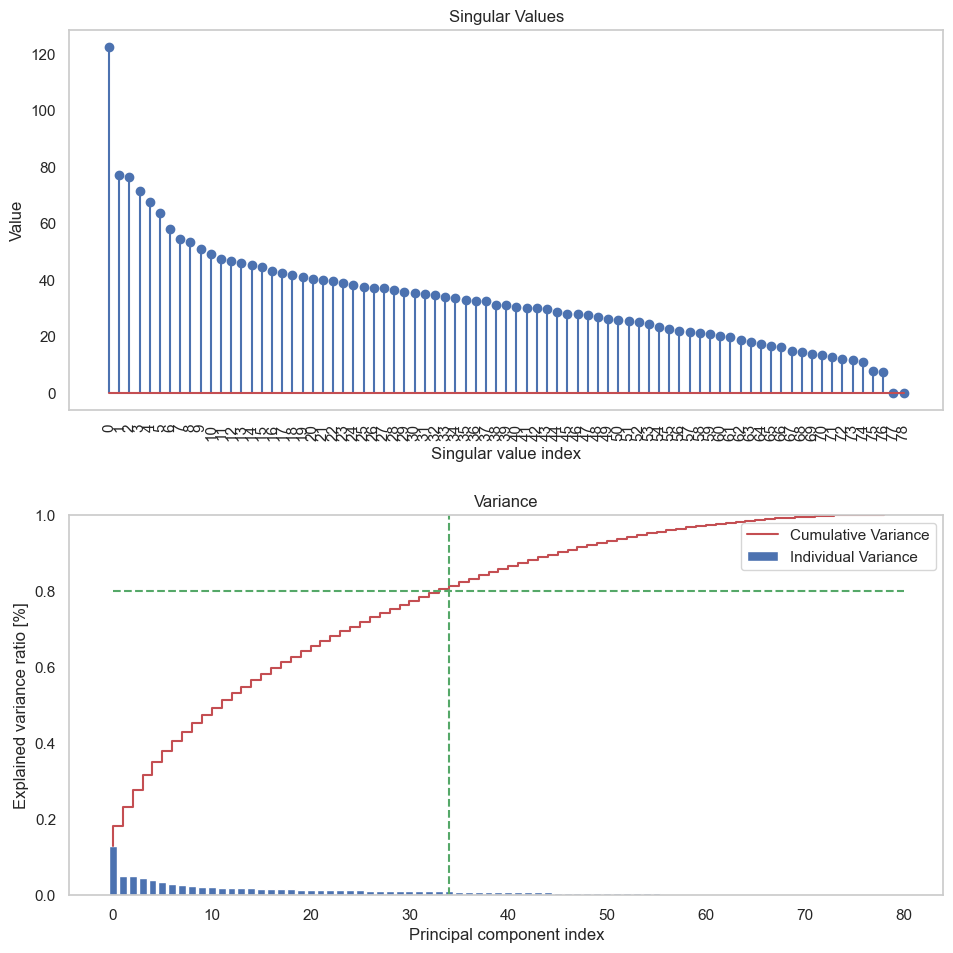

In [169]:
singular_values = pca.singular_values_
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio) #hehe cum
#print(cumulative_explained_variance_ratio)

# plotting the singular values and the histogram of the explained varainces
fig = plt.figure(figsize=(10,10))
plt.subplot(211)
plt.stem(singular_values)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xticks(np.arange(0,len(singular_values),1))
plt.title("Singular Values")
plt.ylabel("Value")
plt.xlabel("Singular value index")
plt.xticks(rotation=90)
plt.grid(visible=False)
plt.subplot(212)
plt.bar(np.arange(0,len(explained_variance_ratio[:]),1), explained_variance_ratio[:], label="Individual Variance")
plt.step(np.arange(0,len(cumulative_explained_variance_ratio[:]),1),cumulative_explained_variance_ratio[:], label="Cumulative Variance", color='r')
# plt.xticks([0,1,2,3,4])
plt.title("Variance")
plt.grid(visible=False)
plt.ylabel("Explained variance ratio [%]")
plt.xlabel("Principal component index")
plt.hlines(0.8, 0,80, linestyles='dashed', colors='g')
plt.vlines(34, 0,1, linestyles='dashed', colors='g')
plt.legend()
plt.ylim((0,1))
fig.tight_layout(pad=2)
plt.show()

With the new dimensionality we can apply a linear regression model to the dataset and then check how accurate the model is to the training data through the explained variance score and the root mean squared error.

In [170]:
# reducing dimensionality
x_train = x_train[:,0:34]
x_test = x_test[:,0:34]

In [171]:
# fit a linear model to the reduced dimension of the input features
# model = sklearn.linear_model.LogisticRegression()
lin_model = sklearn.linear_model.LinearRegression()
lin_model.fit(x_train, train_y)

y_train_pred = lin_model.predict(x_train)

# validate the model on the train data through explained variance score and root mean squared error
ex_var_score = sklearn.metrics.explained_variance_score(train_y.astype('float'), y_train_pred.astype('float'))
print("The explained variance score is:", ex_var_score)
rms_error = sklearn.metrics.root_mean_squared_error(train_y.astype('float'), y_train_pred.astype('float'))
print("The root mean squared error is:", rms_error)

The explained variance score is: 0.8153568343113018
The root mean squared error is: 34124.85032536027


In [192]:
import time ## let me cook 
# ight you do you

In [206]:
# find the predicted values for the test dataset to be evaluated by kaggle
start = time.time_ns()
y_test_pred_lin = lin_model.predict(x_test)[:,np.newaxis]
stop = time.time_ns()
print((stop - start)/ 1459)
y_test_pred_lin_df = pd.DataFrame({'SalePrice' : y_test_pred_lin[:,0]})
print(y_test_pred_lin_df)#
y_test_pred_lin_df.to_csv("./submission_lin.csv")
# y_test_pred_lin_df.to_csv("./kaggle/working/submission_lin.csv")
#685ns/prediction

685.4694996572995
          SalePrice
0     105687.281016
1     165019.036107
2     181879.139997
3     209796.373784
4     200726.827572
...             ...
1454   63081.545533
1455   79512.688814
1456  183483.255432
1457  110197.061391
1458  235569.711866

[1459 rows x 1 columns]


From this we can see that the model is quite accurate in estimating the sale prices given the feature data. There is a relatively low error in the house price that is predicted as is depicted by the root mean squared error. 

### 4.2 Creating a deep learning model

Next we will create a deep learning model. This is a nonlinear model such as the random forest or decision tree model. For this application we will use a fully connected neural network. The neural network will have all the features in the dataset available as the input. Our neural network will consist of an input layer, three hidden layers and an output layer. The input layer and the first hidden layer will have 79 neurons. The second and third hidden layer will have 40 and 30 neurons respectively. Finally the ouput will be determined by a single neuron to output the estimated sale price for a house. 

In [173]:
# creation of the neural network
Layer0 = 79 

layer1 = 79
layer2 = 40
layer3 = 30

LayerOut = 1
model = 0
model = keras.Sequential()

model.add(keras.Input(shape = (Layer0, ))) ## Input Layer
model.add(keras.layers.Dense(layer1, activation='relu'))
model.add(keras.layers.Dense(layer2, activation='relu'))
model.add(keras.layers.Dense(layer3, activation='relu'))
model.add(keras.layers.Dense(LayerOut))

In [174]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 79)             │         6,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 30)             │         1,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,781 (42.11 KB)

 Trainable params: 10,781 (42.11 KB)

 Non-trainable params: 0 (0.00 B)

In [207]:
## compile the model using the mean squared error loss function
model.compile(optimizer='adam', loss='mse') 

In [208]:
 ## (Mantero , 2020) Using batch size to decrease training time

# force the data to be in a NumPy array of floats
x_train_floated = np.asarray(train_x).astype('float32')
y_train_floated = np.asarray(train_y).astype('float32')
x_test_floated = np.asarray(test_x).astype('float32')

# fit the neural network
history = model.fit(x=x_train_floated,y=y_train_floated,
          batch_size=128,epochs=400, verbose=1)



Epoch 1/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 493685152.0000
Epoch 2/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 460343584.0000 
Epoch 3/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 549046464.0000 
Epoch 4/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 555096128.0000 
Epoch 5/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 568751296.0000 
Epoch 6/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 572285824.0000 
Epoch 7/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 436344928.0000 
Epoch 8/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 462385888.0000 
Epoch 9/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 506120448.0000 
Epoch 10/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 451456256.0000 
Epoch 11/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 456935968.0000 
Epoch 12/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 539661824.0000 
Epoch 13/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 463814784.0000 
Epoch 14/400
12/12 ━━━

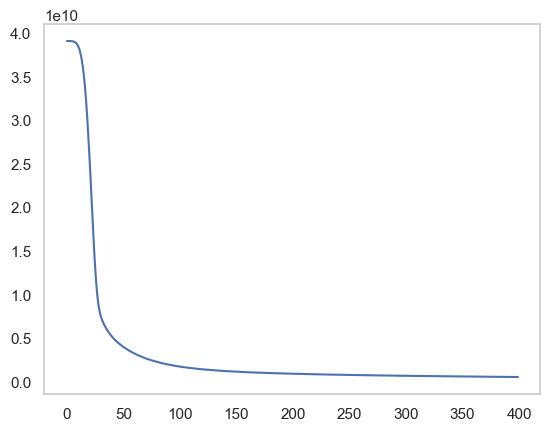

In [177]:
sns.lineplot(data=history.history['loss'])
plt.grid(visible=False)


In [178]:
pred_train = model.predict(x_train_floated)

for i,j in zip(pred_train, y_train_floated):
    print(i,j)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[209599.77] 208500.0
[200423.97] 181500.0
[205913.47] 223500.0
[162989.55] 140000.0
[306478.03] 250000.0
[156751.86] 143000.0
[290180.03] 307000.0
[206684.72] 200000.0
[117714.59] 129900.0
[144618.05] 118000.0
[123565.945] 129500.0
[394168.22] 345000.0
[132559.25] 144000.0
[224300.28] 279500.0
[151947.55] 157000.0
[137645.12] 132000.0
[152289.22] 149000.0
[87917.125] 90000.0
[162142.06] 159000.0
[124831.21] 139000.0
[353215.16] 325300.0
[136378.33] 139400.0
[228847.9] 230000.0
[124043.05] 129900.0
[158477.2] 154000.0
[236804.92] 256300.0
[131511.19] 134800.0
[288859.38] 306000.0
[188951.66] 207500.0
[103689.32] 68500.0
[95250.56] 40000.0
[141789.28] 149350.0
[191334.42] 179900.0
[185625.88] 165500.0
[290003.03] 277500.0
[332897.47] 309000.0
[138752.75] 145000.0
[150278.84] 153000.0
[149694.72] 109000.0
[78681.67] 82000.0
[154881.55] 160000.0
[154923.81] 170000.0
[146424.78] 144000.0
[114747.37] 130250.0
[137087.52] 141000.0
[298256.88] 319900.0
[2

Now that our model is trained we will validate the accuracy of the model in the same way as the linear model, with the explained variance score and the root mean squared error. This shows us that the neural network is more accurate than the linear regression model. The variance that the neural network explains is higher than the variance that the linear model explains and the root mean squared error is lower as well. Meaning that the neural network has an edge over the linear model. In the case of the training data.

In [179]:
# scoring the neural network outputs in the same manner as the pca outputs
ex_var_score = sklearn.metrics.explained_variance_score(train_y.astype('float'), pred_train.astype('float'))
print("The explained variance score is:", ex_var_score)
rms_error = sklearn.metrics.root_mean_squared_error(train_y.astype('float'), pred_train.astype('float'))
print("The root mean squared error is:", rms_error)

The explained variance score is: 0.9220134377647269
The root mean squared error is: 22179.206663740497


In [204]:
# find the predicted values for the test dataset to be evaluated by kaggle
y_test_pred_nn = model.predict(x_test_floated)
y_test_pred_nn_df = pd.DataFrame({'SalePrice' : y_test_pred_nn[:,0]})
print(y_test_pred_nn_df)
y_test_pred_nn_df.to_csv("./submission_nn.csv")
# y_test_pred_nn_df.to_csv("./kaggle/working/submission_nn.csv")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
          SalePrice
0     127122.304688
1     167101.218750
2     172328.562500
3     187201.375000
4     179882.703125
...             ...
1454  103027.609375
1455   93821.398438
1456  174651.406250
1457   81776.242188
1458  246446.968750

[1459 rows x 1 columns]


# 5. Conclusion

To conclude we can see that we have created two relatively accurate models for predicting housing prices.

The given kaggle scores for the linear model is: 
and for the neural network :

Here you can see that the neural network behaves better over the tested dataset. This even though that the neural network is less work to design a primitive model of. This however comes at the cost of training and runtime complexity. Both taking 3 orders of magnitude more time to compute in the neural network case.

# 6. Discussion

!!!discussion on possible feature engineering 

!!!discussion on linear model

Our nonlinear model is a simple neural network. The neural network could possibly improved through using different more comples layers such as pooling layers and bidirectional layers. The use of a different nonlinear model could also be a possibility as there are plenty of other nonlinear models that have their pros and cons. (Sarvandani, 2023) discusses the 11 most used nonlinear models currently and shows how to implement them in a basic form.



# N. References

- Predicting House Prices (Keras - ANN), Tomas Mantero, 2020, https://www.kaggle.com/code/tomasmantero/predicting-house-prices-keras-ann/notebook
- Top 11 algorithms of non-linear regression in machine learning + Proposed Python library+Python code, Mohamadhasan Sarvandani, 2023, https://medium.com/@mohamadhasan.sarvandani/top-algorithms-of-non-linear-regression-in-machine-learning-proposed-python-library-and-python-c871752ddd81